In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

BATCH_SIZE = 1
IMAGE_SIZE = 256
EPOCHS = 3
CHANNEL = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage_Apple",shuffle = True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size= BATCH_SIZE)

Found 3171 files belonging to 4 classes.


In [2]:
class_names = dataset.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [3]:
def get_dataset_partition(dataset, train_split = 0.8, test_split = 0.1,val_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split + val_split)==1

    data_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split*data_size)
    val_size = int(val_split*data_size)

    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size).skip(val_size)

    return train_data,val_data,test_data

train_data, val_data, test_data = get_dataset_partition(dataset=dataset)

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [4]:
resize_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),layers.experimental.preprocessing.Rescaling(1.0/255)])
augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2),layers.experimental.preprocessing.RandomZoom(0.2)])

In [5]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
n_class = 15
model = tf.keras.Sequential(
    [resize_rescale,
    augmentation,
    layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_class,activation='softmax')]
)

model.build(input_shape=input_shape)

In [6]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 256, 256, 3)          0         
                                                                 
 sequential_1 (Sequential)   (1, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (1, 256, 256, 16)         448       
                                                                 
 batch_normalization (BatchN  (1, 256, 256, 16)        64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (1, 128, 128, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (1, 128, 128, 16)        

In [7]:
model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [8]:
history = model.fit(train_data,batch_size= BATCH_SIZE,validation_data = val_data,verbose = 1,epochs = EPOCHS)

Epoch 1/3
2536/2536 [==============================] - 562s 219ms/step - loss: 1.3662 - accuracy: 0.5319 - val_loss: 13.0807 - val_accuracy: 0.5426
Epoch 2/3
2536/2536 [==============================] - 4668s 2s/step - loss: 0.9419 - accuracy: 0.6621 - val_loss: 13.6383 - val_accuracy: 0.5457
Epoch 3/3
2536/2536 [==============================] - 952s 375ms/step - loss: 0.7860 - accuracy: 0.7535 - val_loss: 10.0916 - val_accuracy: 0.4953


In [9]:
score = model.evaluate(test_data)


318/318 [==============================] - 21s 59ms/step - loss: 10.9340 - accuracy: 0.4843


In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

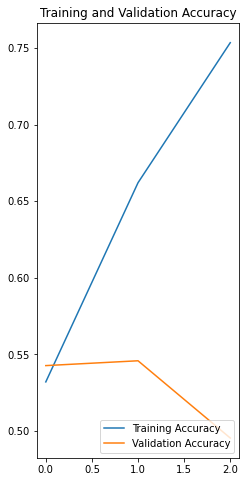

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


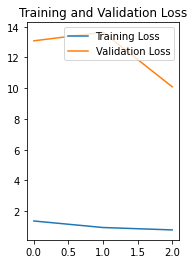

In [12]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 